In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns",100) # 100 yerine None yazilabiliyormus

In [2]:

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge,Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

## Import Data

In [3]:
df_2016 = pd.read_csv('date-hour-soo-dest-2016.csv')
df_2017 = pd.read_csv('date-hour-soo-dest-2017.csv')

# DataFrame'leri birleştir
df = pd.concat([df_2016, df_2017])

df.head()

,Origin,Destination,Throughput,DateTime
0,12TH,12TH,1,2016-01-01 00:00:00
1,12TH,16TH,1,2016-01-01 00:00:00
2,12TH,24TH,4,2016-01-01 00:00:00
3,12TH,ASHB,4,2016-01-01 00:00:00
4,12TH,BALB,2,2016-01-01 00:00:00


In [4]:
df['DateTime']=pd.to_datetime(df['DateTime'])
df['Year']=df['DateTime'].dt.year
df['Month']=df['DateTime'].dt.month
df['Weekday']=df['DateTime'].dt.dayofweek
df['Month_Name']=df['DateTime'].dt.month_name()
df['Weekday_Name']=df['DateTime'].dt.day_name()
df['Hour'] = df['DateTime'].dt.hour

df=df.drop('DateTime',axis=1)
df.head()

,Origin,Destination,Throughput,Year,Month,Weekday,Month_Name,Weekday_Name,Hour
0,12TH,12TH,1,2016,1,4,January,Friday,0
1,12TH,16TH,1,2016,1,4,January,Friday,0
2,12TH,24TH,4,2016,1,4,January,Friday,0
3,12TH,ASHB,4,2016,1,4,January,Friday,0
4,12TH,BALB,2,2016,1,4,January,Friday,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13285207 entries, 0 to 3313624
Data columns (total 9 columns):
 #   Column        Dtype 
---  ------        ----- 
 0   Origin        object
 1   Destination   object
 2   Throughput    int64 
 3   Year          int32 
 4   Month         int32 
 5   Weekday       int32 
 6   Month_Name    object
 7   Weekday_Name  object
 8   Hour          int32 
dtypes: int32(4), int64(1), object(4)
memory usage: 810.9+ MB


In [6]:
station_info=pd.read_csv('station_info.csv')
station_info.head()

,Abbreviation,Description,Location,Name
0,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)
1,16TH,"2000 Mission Street, San Francisco CA 94110<br...","-122.419694,37.765062,0",16th St. Mission (16TH)
2,19TH,"1900 Broadway, Oakland CA 94612<br />19th Stre...","-122.268602,37.808350,0",19th St. Oakland (19TH)
3,24TH,"2800 Mission Street, San Francisco CA 94110<br...","-122.418143,37.752470,0",24th St. Mission (24TH)
4,ASHB,"3100 Adeline Street, Berkeley CA 94703<br />As...","-122.270062,37.852803,0",Ashby (ASHB)


# Data Analytics Questions

### Which BART station is the busiest?

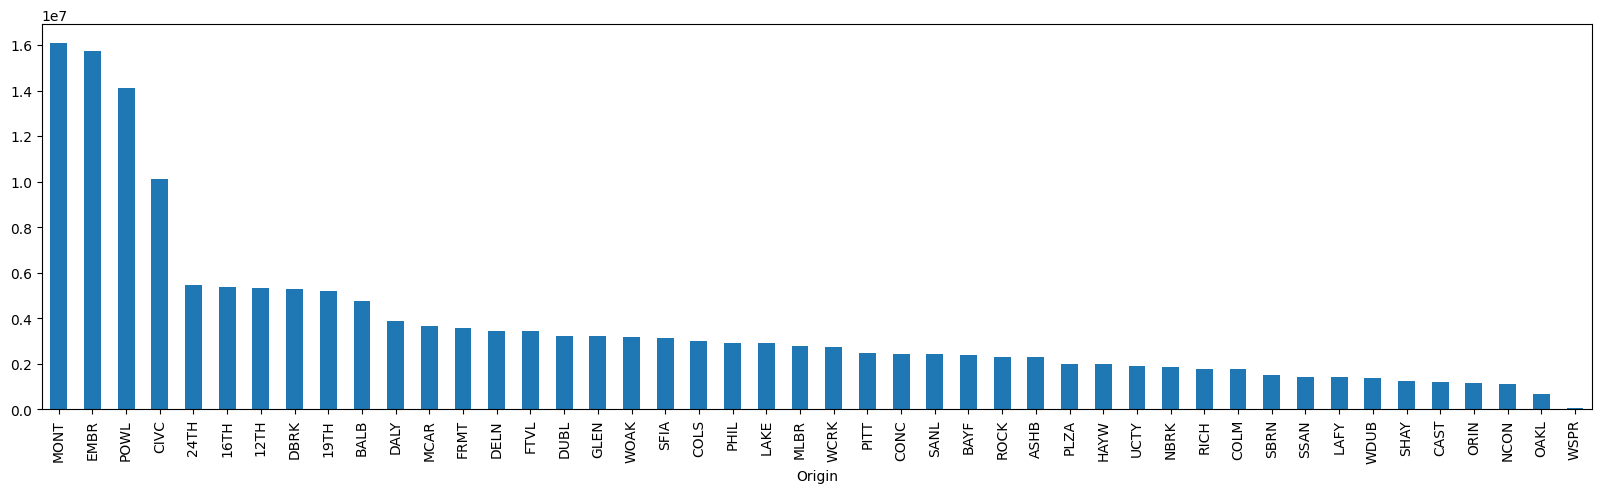

In [7]:
plt.figure(figsize=(20,5))
df.groupby('Origin')['Throughput'].sum().sort_values(ascending=False).plot.bar();

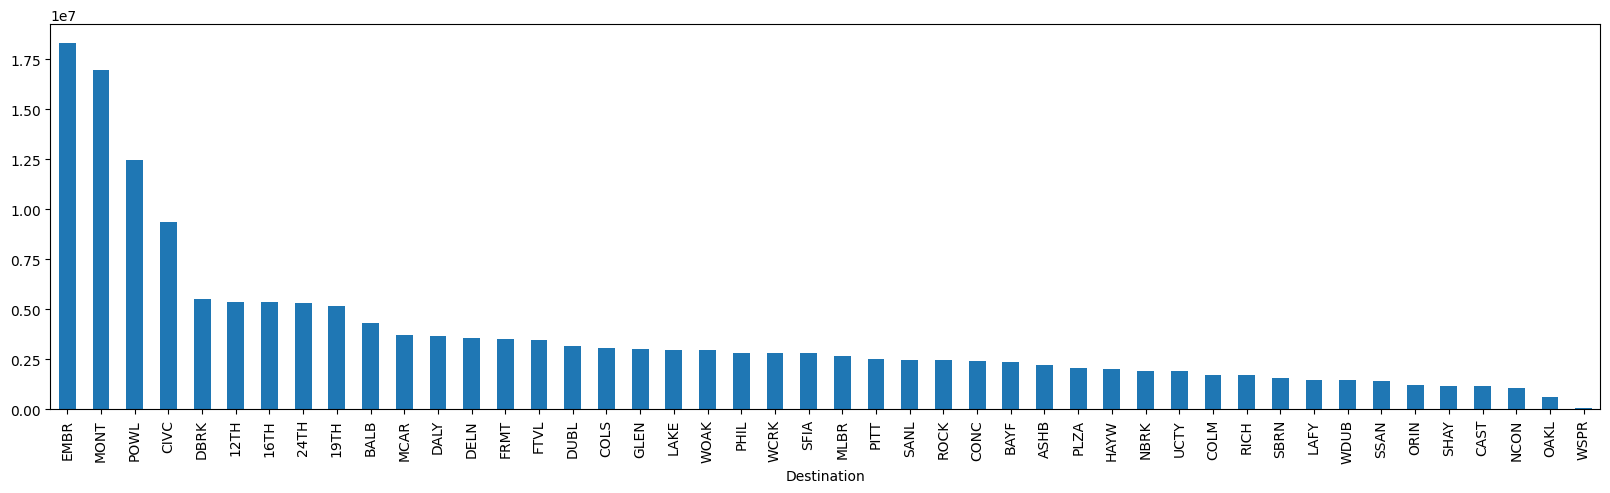

In [8]:
plt.figure(figsize=(20,5))
df.groupby('Destination')['Throughput'].sum().sort_values(ascending=False).plot.bar();

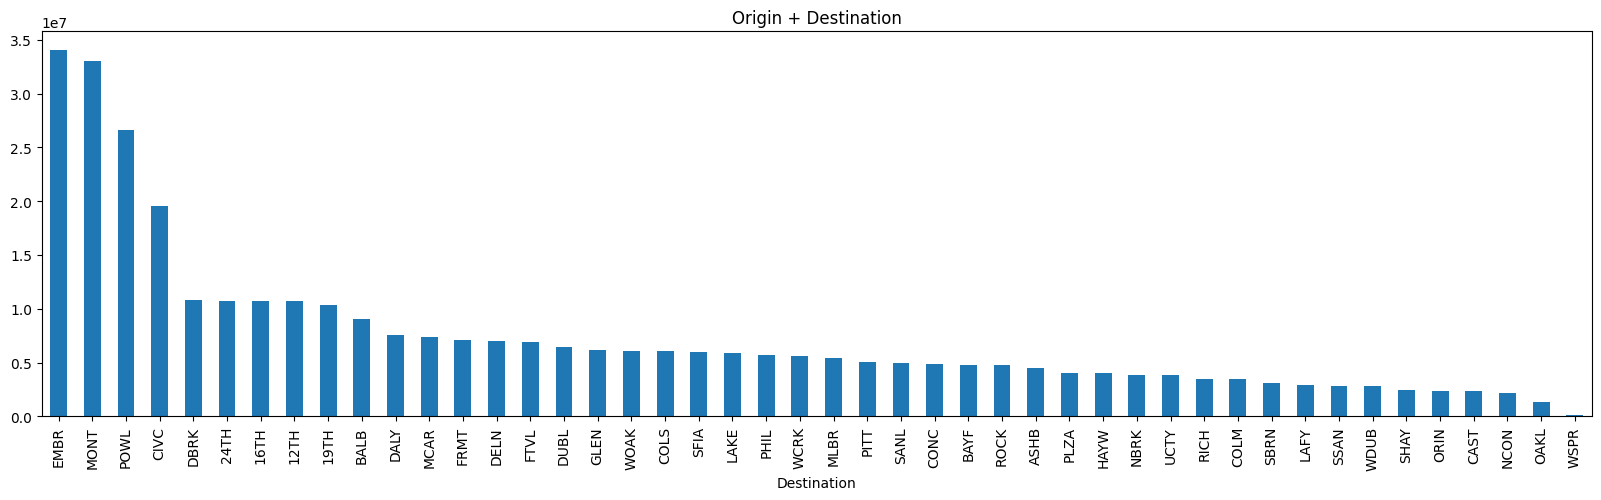

In [9]:
plt.figure(figsize=(20,5))
(df.groupby('Destination')['Throughput'].sum() + df.groupby('Origin')['Throughput'].sum()).sort_values(ascending=False).plot.bar()
plt.title('Origin + Destination');

Gidis ve donusler beraber goz onune alindiginda en yogun istasyon:

In [10]:
station_info[station_info.Abbreviation=='EMBR'].Name

16    Embarcadero (EMBR)
Name: Name, dtype: object

### When is the best time to go to SF from Berkeley if you want to find a seat?

In [11]:
# Berkeley'den SF'ye giden yolcuları filtrele
berkeley_sf = df[(df['Origin'] == 'DBRK') & (df['Destination'].isin(['EMBR', 'MONT', 'CIVC', 'POWL']))]


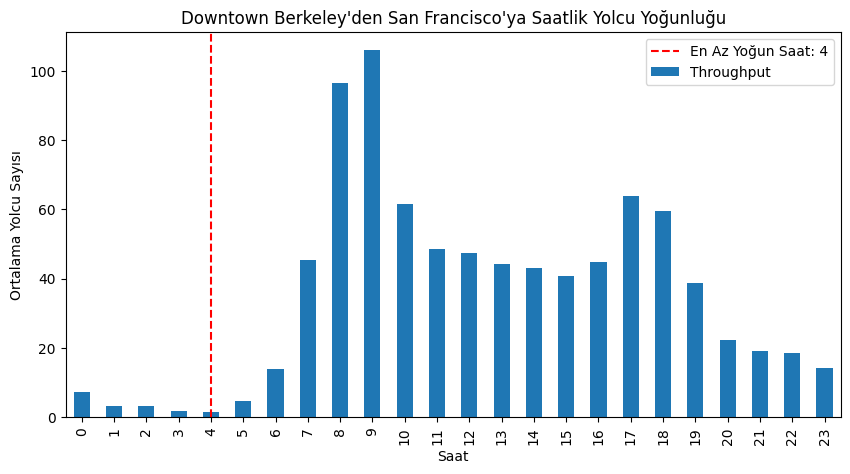

Downtown Berkeley'den San Francisco'ya seyahat için en az yoğun saat: 4


In [12]:
# Eğer veri yoksa, hata mesajı ver
if berkeley_sf.empty:
    print("Filtreleme kriterleriniz veri setinde eşleşen veri bulamadı. Lütfen istasyon adlarını kontrol edin.")
else:
    # Saatlik yolcu sayılarına bak
    hourly_passengers = berkeley_sf.groupby('Hour')['Throughput'].mean()

    # En az yoğun saatleri bul
    least_busy_hour = hourly_passengers.idxmin()

    # Sonuçları görselleştir
    plt.figure(figsize=(10, 5))
    hourly_passengers.plot(kind='bar')
    plt.title('Downtown Berkeley\'den San Francisco\'ya Saatlik Yolcu Yoğunluğu')
    plt.xlabel('Saat')
    plt.ylabel('Ortalama Yolcu Sayısı')
    plt.axvline(x=least_busy_hour, color='r', linestyle='--', label='En Az Yoğun Saat: {}'.format(least_busy_hour))
    plt.legend()
    plt.show()

    # En az yoğun saatleri yazdır
    print(f"Downtown Berkeley'den San Francisco'ya seyahat için en az yoğun saat: {least_busy_hour}")


### What is the least popular BART route?

In [13]:
df['route'] = df['Origin']+df['Destination']

<Axes: xlabel='route'>

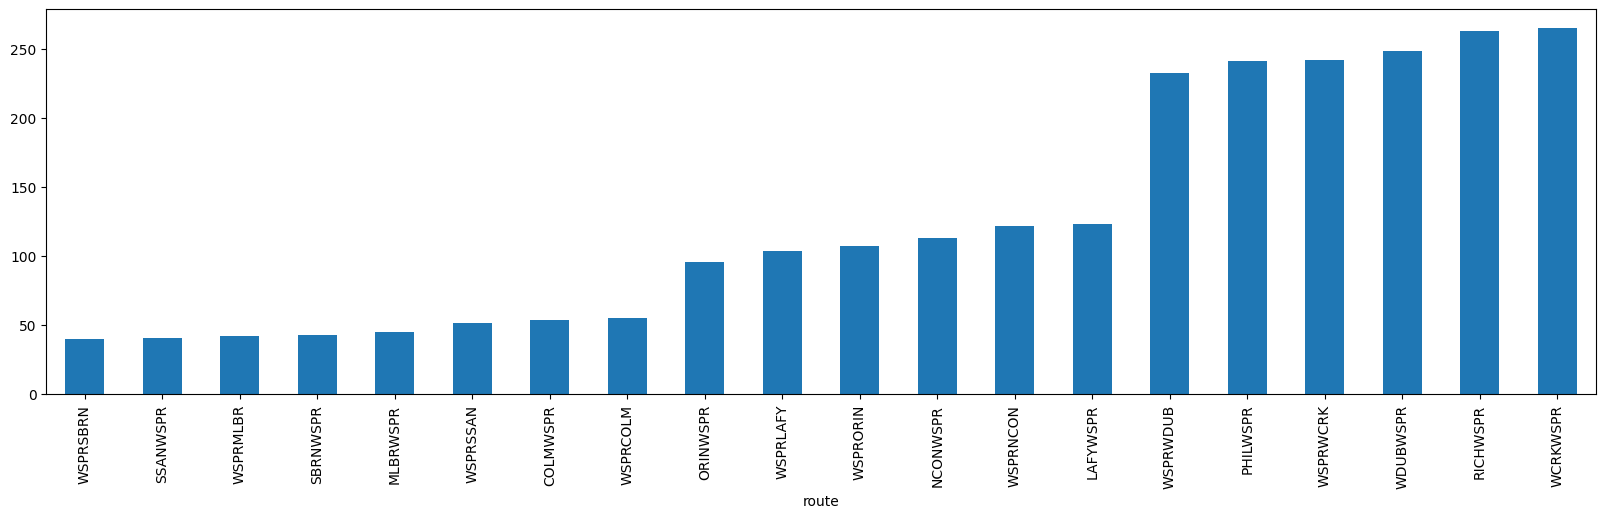

In [14]:
plt.figure(figsize=(20,5))
df.groupby('route')['Throughput'].sum().sort_values(ascending=True)[:20].plot.bar()

### When is the best time to go to SF from Berkeley if you want to find a seat?

In [15]:
df[(df['Origin']=='DBRK') & (df['Destination']=='SSAN')].groupby(['Weekday_Name','Hour'])['Throughput'].sum().sort_values(ascending=True)

Weekday_Name  Hour
Thursday      1         1
Friday        2         2
Sunday        3         2
Wednesday     1         2
Monday        1         2
                     ... 
              18      423
Friday        17      428
Wednesday     17      448
Tuesday       17      454
              18      518
Name: Throughput, Length: 145, dtype: int64

**En musait zaman:**
- Persembe 01:00

## Which day of the week is the busiest? 

<Axes: xlabel='Weekday_Name'>

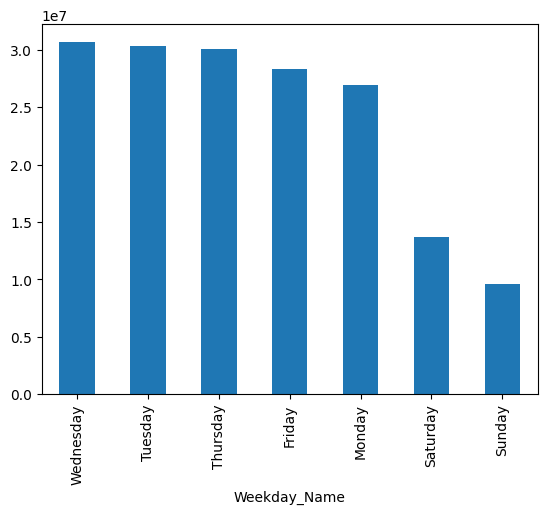

In [16]:
df.groupby('Weekday_Name')['Throughput'].sum().sort_values(ascending=False).plot.bar()

## How many people take the BART late at night?

In [17]:
df[(df['Hour']>0) & (df['Hour']<=5)]['Throughput'].sum()

2378622

# Data Science Questions

## Compute the straight line distance between every station

In [18]:
station_info.head()

,Abbreviation,Description,Location,Name
0,12TH,"1245 Broadway, Oakland CA 94612<br />12th St. ...","-122.271450,37.803768,0",12th St. Oakland City Center (12TH)
1,16TH,"2000 Mission Street, San Francisco CA 94110<br...","-122.419694,37.765062,0",16th St. Mission (16TH)
2,19TH,"1900 Broadway, Oakland CA 94612<br />19th Stre...","-122.268602,37.808350,0",19th St. Oakland (19TH)
3,24TH,"2800 Mission Street, San Francisco CA 94110<br...","-122.418143,37.752470,0",24th St. Mission (24TH)
4,ASHB,"3100 Adeline Street, Berkeley CA 94703<br />As...","-122.270062,37.852803,0",Ashby (ASHB)


In [19]:
station_info['longitude'] = station_info.Location.apply(lambda x: float(x.split(',')[0]))
station_info['latitude'] = station_info.Location.apply(lambda x: float(x.split(',')[1]))

In [20]:
stationsA=station_info[["Abbreviation","latitude","longitude"]]
stationsB=station_info[["Abbreviation","latitude","longitude"]]

In [21]:
stationsA[["longitude","latitude"]]=stationsA[["longitude","latitude"]].astype("float")
stationsB[["longitude","latitude"]]=stationsB[["longitude","latitude"]].astype("float")

In [22]:
stationsA[['lat_radians_A','long_radians_A']] = np.radians(stationsA[['latitude','longitude']])
stationsB[['lat_radians_B','long_radians_B']] = np.radians(stationsB[['latitude','longitude']])

In [23]:
from sklearn.metrics import DistanceMetric
stationsA['lat_radians_A'] = np.radians(stationsA['latitude'])
stationsA['long_radians_A'] = np.radians(stationsA['longitude'])
stationsB['lat_radians_B'] = np.radians(stationsB['latitude'])
stationsB['long_radians_B'] = np.radians(stationsB['longitude'])

dist = DistanceMetric.get_metric('haversine')

# İstasyonlar arası mesafeleri hesapla
dist_matrix = dist.pairwise(
    stationsA[['lat_radians_A', 'long_radians_A']].to_numpy(),
    stationsB[['lat_radians_B', 'long_radians_B']].to_numpy()
) * 6371  # Dünya'nın yarıçapı kilometre cinsinden

# Sonuçları DataFrame'e dönüştürme
df_dist_matrix = pd.DataFrame(
    dist_matrix,
    index=stationsA['Abbreviation'],
    columns=stationsB['Abbreviation']
)
print(df_dist_matrix)


Abbreviation       12TH       16TH       19TH       24TH       ASHB  \
Abbreviation                                                          
12TH           0.000000  13.720175   0.567617  14.097927   5.453806   
16TH          13.720175   0.000000  14.123076   1.406790  16.370223   
19TH           0.567617  14.123076   0.000000  14.537177   4.944611   
24TH          14.097927   1.406790  14.537177   0.000000  17.138578   
ASHB           5.453806  16.370223   4.944611  17.138578   0.000000   
BALB          17.972899   5.417745  18.449743   4.296647  21.355016   
BAYF          17.421986  26.873362  17.594397  26.382151  21.438504   
CAST          21.318066  31.369785  21.423040  30.899845  24.836544   
CIVC          12.818548   1.703137  13.176704   3.051922  15.038489   
COLS           8.602724  19.629420   8.759155  19.454198  12.762538   
COLM          21.651800   9.834954  22.162579   8.647687  25.435815   
CONC          28.452150  41.399854  27.927226  42.092373  25.053770   
DALY  

In [24]:
df_dist_matrix

Abbreviation,12TH,16TH,19TH,24TH,ASHB,BALB,BAYF,CAST,CIVC,COLS,COLM,CONC,DALY,DBRK,DELN,DUBL,EMBR,FRMT,FTVL,GLEN,HAYW,LAFY,LAKE,MCAR,MLBR,MONT,NBRK,NCON,OAKL,ORIN,PHIL,PITT,PLZA,POWL,RICH,ROCK,SANL,SBRN,SFIA,SHAY,SSAN,UCTY,WARM,WCRK,WDUB,WOAK
Abbreviation,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
12TH,0.000000,13.720175,0.567617,14.097927,5.453806,17.972899,17.421986,21.318066,12.818548,8.602724,21.651800,28.452150,20.488348,7.381976,14.064957,34.641522,11.099285,37.726994,5.254274,16.294042,22.027147,16.279546,0.930228,2.839447,24.795767,11.500185,7.876464,30.993614,11.334582,11.315857,23.450324,37.305931,11.254330,12.186511,16.442537,4.881371,13.315746,22.428251,23.437267,26.644817,21.698728,32.578345,44.493097,21.179219,32.315075,2.084928
16TH,13.720175,0.000000,14.123076,1.406790,16.370223,5.417745,26.873362,31.369785,1.703137,19.629420,9.834954,41.399854,7.862292,17.710613,19.956444,46.313509,3.678977,45.322092,17.219854,3.768466,31.123107,29.571877,14.036737,15.184031,18.552504,3.163421,17.025981,43.624344,19.134809,24.249960,36.740696,50.306911,18.615264,2.391407,19.977128,17.236833,23.259691,14.158399,16.751655,35.047867,11.411739,40.370112,51.419301,34.647001,43.824988,11.806930
19TH,0.567617,14.123076,0.000000,14.537177,4.944611,18.449743,17.594397,21.423040,13.176704,8.759155,22.162579,27.927226,20.972364,6.866855,13.652407,34.575547,11.413346,37.927682,5.396993,16.761912,22.193837,15.772063,1.294459,2.307486,25.363052,11.827735,7.411705,30.454558,11.680862,10.773359,22.948482,36.787537,10.815966,12.530541,16.099056,4.316179,13.491787,22.989786,24.004818,26.832791,22.238484,32.780913,44.714838,20.697326,32.267711,2.363310
24TH,14.097927,1.406790,14.537177,0.000000,17.138578,4.296647,26.382151,30.899845,3.051922,19.454198,8.647687,42.092373,6.828586,18.567582,21.157028,45.989716,4.861216,44.508828,17.231066,2.560421,30.546688,30.156601,14.327988,15.774585,17.148474,4.372678,17.959316,44.384429,18.629589,24.894688,37.339178,50.997728,19.709716,3.668896,21.283104,17.885535,22.878946,12.756104,15.346553,34.367219,10.069632,39.597423,50.525350,35.183337,43.483323,12.280671
ASHB,5.453806,16.370223,4.944611,17.138578,0.000000,21.355016,21.438504,24.836544,15.038489,12.762538,25.435815,25.053770,23.915627,1.931222,9.023275,36.672412,12.990622,41.772579,9.560819,19.604034,25.948929,13.531585,6.216814,2.652851,29.895394,13.494601,2.630089,27.257098,16.331015,8.088818,20.581818,33.957113,6.091619,14.299741,11.850630,1.872092,17.430801,27.148960,28.448090,30.663606,25.948183,36.657191,48.655719,18.717531,34.527755,5.766857
BALB,17.972899,5.417745,18.449743,4.296647,21.355016,0.000000,28.370186,32.896601,7.100637,22.326582,4.426359,46.215044,2.560946,22.828351,25.374187,48.284910,9.084916,45.301700,20.509238,1.754601,32.237574,34.185441,18.090735,19.859788,14.512558,8.575488,22.246533,48.564235,20.718954,28.995894,41.370956,55.112936,23.993534,7.808705,25.332068,22.011712,25.213150,9.717283,12.706137,35.692841,6.383547,40.567612,50.980852,39.147064,45.742854,16.283721
BAYF,17.421986,26.873362,17.594397,26.382151,21.438504,28.370186,0.000000,4.531980,26.914792,8.836838,29.923394,31.947031,30.155769,22.928463,30.382150,20.008136,26.068034,20.365540,12.198752,27.328128,4.607425,21.822855,16.508945,19.196143,25.303058,26.239989,24.035914,35.210338,7.752571,20.793251,26.480943,39.184309,27.433911,26.594946,33.285280,19.759903,4.106354,26.340207,25.078559,9.252500,28.171545,15.232015,27.220506,23.766972,17.447384,19.075498
CAST,21.318066,31.369785,21.423040,30.899845,24.836544,32.896601,4.531980,0.000000,31.370282,12.755491,34.380122,31.731127,34.661193,26.154416,33.585225,15.570095,30.458562,17.194416,16.066778,31.860095,2.544392,22.917755,20.433426,22.798554,29.179789,30.649412,27.362164,35.029355,12.274283,22.926198,26.489444,38.245665,30.660487,31.029730,36.648450,23.060080,8.262625,30.561191,29.103355,6.474328,32.551621,12.255757,24.163189,23.892538,13.004394,23.100389
CIVC,12.818548,1.703137,13.176704,3.051922,15.038489,7.10

## Build a model that can predicted the number of people commuting to work by Bart between any 2 stations.

Gunluk ortalama saat basi kac kisi oldugunu bulup ise giris ve cikis saatlerinden cikarabiliriz.

In [25]:
df_new = df[df.Weekday<=4] # Hafta ici 

In [26]:
df_new

,Origin,Destination,Throughput,Year,Month,Weekday,Month_Name,Weekday_Name,Hour,route
0,12TH,12TH,1,2016,1,4,January,Friday,0,12TH12TH
1,12TH,16TH,1,2016,1,4,January,Friday,0,12TH16TH
2,12TH,24TH,4,2016,1,4,January,Friday,0,12TH24TH
3,12TH,ASHB,4,2016,1,4,January,Friday,0,12THASHB
4,12TH,BALB,2,2016,1,4,January,Friday,0,12THBALB
...,...,...,...,...,...,...,...,...,...,...
3313620,WSPR,MONT,1,2017,5,2,May,Wednesday,23,WSPRMONT
3313621,WSPR,NBRK,1,2017,5,2,May,Wednesday,23,WSPRNBRK
3313622,WSPR,NCON,1,2017,5,2,May,Wednesday,23,WSPRNCON
3313623,WSPR,SANL,2,2017,5,2,May,Wednesday,23,WSPRSANL


In [27]:
df_new['mean_Throughput'] = df_new.groupby(['route', 'Hour'])['Throughput'].transform('mean') # Her rotanin saat basi ortalama yolcu sayisi

**giris 8:00 cikis 17:00 kabul edersek**

In [28]:
df_new['work'] = df_new['mean_Throughput'] - df_new['Throughput']

In [29]:
df_new[(df_new.Hour==8) | (df_new.Hour==17)]

,Origin,Destination,Throughput,Year,Month,Weekday,Month_Name,Weekday_Name,Hour,route,mean_Throughput,work
3068,12TH,16TH,1,2016,1,4,January,Friday,8,12TH16TH,29.355301,28.355301
3069,12TH,19TH,1,2016,1,4,January,Friday,8,12TH19TH,5.111111,4.111111
3070,12TH,24TH,1,2016,1,4,January,Friday,8,12TH24TH,12.445087,11.445087
3071,12TH,ASHB,1,2016,1,4,January,Friday,8,12THASHB,8.239067,7.239067
3072,12TH,BALB,2,2016,1,4,January,Friday,8,12THBALB,6.533724,4.533724
...,...,...,...,...,...,...,...,...,...,...,...,...
3305086,WSPR,SHAY,10,2017,5,2,May,Wednesday,17,WSPRSHAY,4.740741,-5.259259
3305087,WSPR,UCTY,14,2017,5,2,May,Wednesday,17,WSPRUCTY,7.607143,-6.392857
3305088,WSPR,WCRK,1,2017,5,2,May,Wednesday,17,WSPRWCRK,1.181818,0.181818
3305089,WSPR,WDUB,1,2017,5,2,May,Wednesday,17,WSPRWDUB,1.357143,0.357143


In [30]:
# Gerekli olabilecek ek verileri listele
additional_data = {
    "Demographic Info": "Yaş, cinsiyet, meslek gibi yolcuların demografik bilgileri",
    "Survey Data": "Yolcuların seyahat deneyimleri ve memnuniyet düzeyleri hakkında bilgiler",
    "Weather Data": "Hava durumu verileri, yolcu yoğunluğu üzerindeki etkileri anlamak için",
    "Special Events": "Özel etkinlikler sırasında yolcu sayılarında değişiklikler"
}

# Ek verileri yazdır
for data_type, description in additional_data.items():
    print(f"{data_type}: {description}")


Demographic Info: Yaş, cinsiyet, meslek gibi yolcuların demografik bilgileri
Survey Data: Yolcuların seyahat deneyimleri ve memnuniyet düzeyleri hakkında bilgiler
Weather Data: Hava durumu verileri, yolcu yoğunluğu üzerindeki etkileri anlamak için
Special Events: Özel etkinlikler sırasında yolcu sayılarında değişiklikler


In [31]:
# Verilerin kullanım şekillerini açıkla
usage_of_data = {
    "Traffic Management": "En yoğun olmayan saatleri teşvik etmek için indirimler veya promosyonlar sunulabilir",
    "Capacity Planning": "Daha az yoğun saatlerde daha az tren seferi düzenlenerek maliyetler düşürülebilir",
    "Policy Development": "Veriye dayalı kararlar alınarak, toplu taşıma kullanımını teşvik edecek politikalar geliştirilebilir"
}

# Kullanım şekillerini yazdır
for usage, description in usage_of_data.items():
    print(f"{usage}: {description}")


Traffic Management: En yoğun olmayan saatleri teşvik etmek için indirimler veya promosyonlar sunulabilir
Capacity Planning: Daha az yoğun saatlerde daha az tren seferi düzenlenerek maliyetler düşürülebilir
Policy Development: Veriye dayalı kararlar alınarak, toplu taşıma kullanımını teşvik edecek politikalar geliştirilebilir
